# Grad-CAM
visualize attention of the network

In [8]:
# from VAE_grad_cam import *
from LinearVAE_grad_cam import *

import sys
sys.path.append("../Reconstruction/")
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [9]:
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
# import torch.utils.data
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
# import models
# import utils.flops as flops

# import Reconstruction.models as models



import argparse, os, pickle, glob, cv2
import matplotlib.pyplot as plt
import numpy as np

from utils.loss_function import select_loss_function
from utils.get_cdim import update_code_dim

from data.dataset import StanfordDog
from Solver import LinearSolver, ConvSolver

from models.simpleAE import simpleAE
from models.LinearVAE import LinearVAE
from models.ConvVAE import ConvVAE

from torchvision.datasets import MNIST
from scipy.stats import norm

from copy import deepcopy

In [10]:
channel = 3
picReslu = 96
# model = ConvVAE(c_dim=update_code_dim(128, picReslu, 4), z_dim=1024, num_channels=channel) # the update_code_dim means(num_filters_in_final_layer, img_size, num_conv_layers)
zdim = 16
model = LinearVAE(z_dim=zdim, hidden=512, num_channels=32*32)
model = model.cuda()

# checkpoints = glob.glob(pathname='../Reconstruction/r{}_dog_check/ConvVAE*'.format(picReslu))
# checkpoints = glob.glob(pathname = '../Reconstruction/checkpoints/*')
checkpoints = glob.glob(pathname = '../Reconstruction/minst_checkpoints/LinearVAE_%d.pth'%zdim)


if len(checkpoints) != 0:
    model.load(path=checkpoints[0])
    print("loaded:", checkpoints[0])
    
# batch_size = 32
# train_loader = torch.utils.data.DataLoader(dataset=StanfordDog(root='/home/hexpodmlc/thankyou/CS385ML/Reconstruction/data', train=True), batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=StanfordDog(root='/home/hexpodmlc/thankyou/CS385ML/Reconstruction/data', train=False), batch_size=batch_size, shuffle=True)


loaded: ../Reconstruction/minst_checkpoints/LinearVAE_16.pth


In [11]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (picReslu,) * 2) # this 32 is correspondent to the 32 in c_dim
    image = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

In [39]:
images = []
raw_images = []
print("Images:")
#####IMAGES FOR DOG #######
# image_paths = ["../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg"]#,"cat_dog.png"]
# image_paths = ["../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg"]#,"cat_dog.png"]

# for i, image_path in enumerate(image_paths):
#     print("\t#{}: {}".format(i, image_path))
#     image, raw_image = preprocess(image_path)
#     images.append(image)
#     raw_images.append(raw_image)

# images = torch.stack(images).cuda()

##### IMAGES FOR MNIST #####
train_loader = torch.utils.data.DataLoader(dataset=MNIST('../Reconstruction/data/{0}'.format("mnist"), train=True,download=True ,transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])), batch_size=1, shuffle=True)
images, _ = next(iter(train_loader))
raw_images = images

Images:


###P###: (5, 13)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
images shape: torch.Size([1, 1, 1024])
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


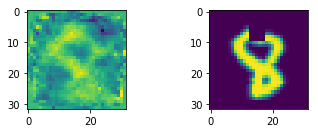

###P###: (15, 10)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
images shape: torch.Size([1, 1, 1024])
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


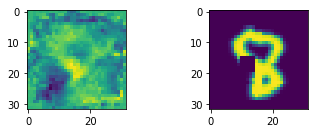

###P###: (7, 15)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
images shape: torch.Size([1, 1, 1024])
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


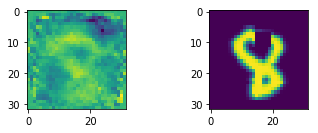

###P###: (20, 10)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
images shape: torch.Size([1, 1, 1024])
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


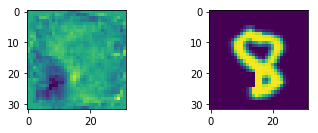

###P###: (10, 20)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
images shape: torch.Size([1, 1, 1024])
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


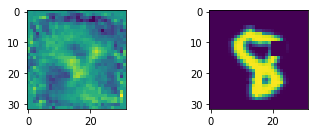

In [40]:
def area_grad_cam(images, raw_images, pos, size = (6,6)):
    
    bp = GuidedBackPropagation(model=model)
    print(images.shape)
    # out = bp.forward(images)
    raws = np.array(raw_images)
    print("raw_shape:",raws.shape )
#     raws = raws.transpose(0,3,1,2) # comment out this in MNIST
    
    images = torch.Tensor(raws).cuda()
    images = images.view(images.shape[0], 1, -1)
    images = images.cuda()
    print("images shape:",images.shape)

    out = bp.forward(images)

    out = out.cpu().detach().numpy()
    print("outshape:",out.shape)

    bp.backward(pos = pos, size = size)
    t_raw_images = deepcopy(raw_images)
    
    t_raw_images[0][:,pos[0][0]:pos[0][0]+size[0],pos[0][1]:pos[0][1]+size[1] ] = 0 # MNIST
#     t_raw_images[0][pos[0][0]:pos[0][0]+size[0],pos[0][1]:pos[0][1]+size[1],: ] = 0

    gradients = bp.generate()
    gradient = gradients[0]
    gradient = gradient.reshape(1,32,32) # MNIST hard coded not good
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    print(gradient.shape)
    gradient = np.uint8(gradient)
    gradient = gradient.reshape(32,32) # add this in MNIST
#     gradient = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY)



#     gcam = GradCAM(model=model,candidate_layers=["Encoder.main.7"])
#     _ = gcam.forward(images)
#     gcam.backward(pos,size)
#     regions = gcam.generate(target_layer="Encoder.main.7")


    plt.subplot(221)
    plt.imshow(gradient)#,"gray")
    plt.subplot(222)
    plt.imshow(t_raw_images[0][0,:,:]) #MNIST
#     plt.imshow(t_raw_images[0])

#     plt.subplot(223)
#     plt.imshow(out[0][0,:,:])
# #     plt.imshow(out[0].transpose(1,2,0))

#     plt.subplot(224)
#     print(images.shape)
#     img = images.cpu().detach().numpy()
# #     plt.imshow(img[0].transpose(1,2,0))
#     plt.imshow(img[0].reshape(32,32))

    plt.show()
# area_grad_cam(images, raw_images, pos=np.array([[5,13]]))
# for p in [(5,13),(40,10),(15,45),(60,60),(10,70)]:
for p in [(5,13),(15,10),(7,15),(20,10),(10,20)]:
    print("###P###:",p)
    area_grad_cam(images, raw_images,pos = np.array([[*p]]), size = (5,5))

LAYER:  4
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


/home/hexpodmlc/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


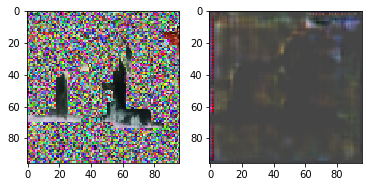

LAYER:  5
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


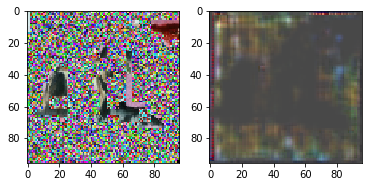

LAYER:  6
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


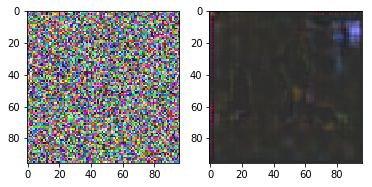

LAYER:  7
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


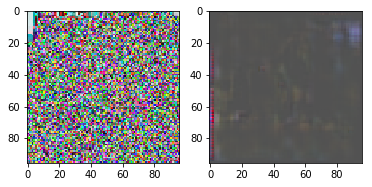

LAYER:  8
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


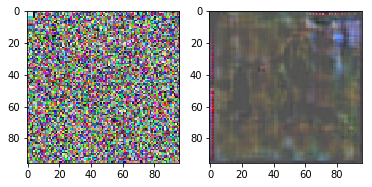

LAYER:  9
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


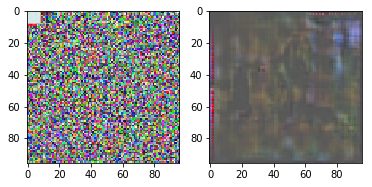

LAYER:  10
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


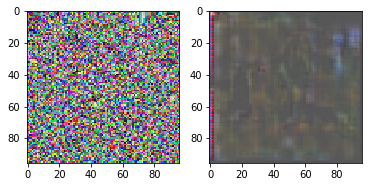

LAYER:  11
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
0.0


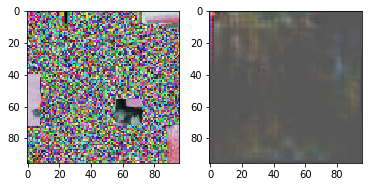

In [84]:
def grad_cam_layer(raw_images,layer):
    raws = np.array(raw_images)
    print("raw_shape:",raws.shape )
    raws = raws.transpose(0,3,1,2)
    images = torch.Tensor(raws).cuda()
    print(images.shape)

    gcam = GradCAM(model=model,candidate_layers=["Encoder.main.%d" %i for i in range(1,12)])
    _ = gcam.forward(images)

    gbp = GuidedBackPropagation(model=model)
    _ = gbp.forward(images)


    pos = np.array([[10,70]])
    size = (20,20)

    gbp.backward(pos,size)
    gradients = gbp.generate()

    # # Grad-CAM

    gcam.backward(pos,size)
    regions = gcam.generate(target_layer="Encoder.main.{}".format(layer))

    grad_gradients = torch.mul(regions, gradients)

    gcam = regions[0,0]
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0

    alpha = gcam[..., None]
    print(alpha.min())
    gcam = alpha * cmap + (1 - alpha) * raw_image

#     gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
#     plt.imshow(raw_image)
    plt.subplot(121)
    plt.imshow(gcam)
    plt.subplot(122)
    
    gradient = grad_gradients[0]
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
#     print(gradient.shape)
    gradient = np.uint8(gradient)
    plt.imshow(gradient)
    
    plt.show()
for i in range(4,12):
    print("LAYER: ",i)
    grad_cam_layer(raw_images,i)

In [66]:
for name, module in gbp.model.named_modules():
    print (name)


Encoder
Encoder.main
Encoder.main.0
Encoder.main.1
Encoder.main.2
Encoder.main.3
Encoder.main.4
Encoder.main.5
Encoder.main.6
Encoder.main.7
Encoder.main.8
Encoder.main.9
Encoder.main.10
Encoder.main.11
Encoder.linear_mu
Encoder.sigma
Decoder
Decoder.main_1
Decoder.main_1.0
Decoder.main_1.1
Decoder.main_1.2
Decoder.main_1.3
Decoder.main_2
Decoder.main_2.0
Decoder.main_2.1
Decoder.main_2.2
Decoder.main_2.3
Decoder.main_2.4
Decoder.main_2.5
Decoder.main_2.6
Decoder.main_2.7
Decoder.main_2.8
Decoder.main_2.9
Decoder.main_2.10
